# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

In [2]:
import time
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import lightgbm as lgb
import matplotlib.pyplot as plt

from random import randint
from tqdm import tqdm_notebook
from xgboost import XGBRegressor
from skimpy import clean_columns
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV, KFold, train_test_split
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, LabelEncoder

/opt/conda/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [3]:
# снимаем ограничение на количество столбцов
pd.set_option('display.max_columns', None)

# снимаем ограничение на ширину столбцов
#pd.set_option('display.max_colwidth', None)

# игнорируем предупреждения
pd.set_option('chained_assignment', None)  

# выставляем ограничение на показ знаков после запятой
pd.options.display.float_format = '{:,.2f}'.format

# устанавливаем стиль графиков
sns.set_style('darkgrid')
sns.set(rc={'figure.dpi':200, 'savefig.dpi':300})   
sns.set_context('notebook')    
sns.set_style('ticks')  

warnings.filterwarnings('ignore')

In [4]:
try:
    data = pd.read_csv('autos.csv') 
except:
    data = pd.read_csv('/datasets/autos.csv')

In [5]:
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [6]:
# Приведем наименования столбцов к хорошему стилю
data = clean_columns(data)
data.head()

16 column names have been cleaned

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   date_crawled        354369 non-null  object
 1   price               354369 non-null  int64 
 2   vehicle_type        316879 non-null  object
 3   registration_year   354369 non-null  int64 
 4   gearbox             334536 non-null  object
 5   power               354369 non-null  int64 
 6   model               334664 non-null  object
 7   kilometer           354369 non-null  int64 
 8   registration_month  354369 non-null  int64 
 9   fuel_type           321474 non-null  object
 10  brand               354369 non-null  object
 11  repaired            283215 non-null  object
 12  date_created        354369 non-null  object
 13  number_of_pictures  354369 non-null  int64 
 14  postal_code         354369 non-null  int64 
 15  last_seen           354369 non-null  object
dtypes:

In [8]:
data.isna().sum()

date_crawled              0
price                     0
vehicle_type          37490
registration_year         0
gearbox               19833
power                     0
model                 19705
kilometer                 0
registration_month        0
fuel_type             32895
brand                     0
repaired              71154
date_created              0
number_of_pictures        0
postal_code               0
last_seen                 0
dtype: int64

In [9]:
data.duplicated().sum()

4

In [10]:
# удалим дубликаты
data = data.drop_duplicates()

In [11]:
data.describe()

,price,registration_year,power,kilometer,registration_month,number_of_pictures,postal_code
count,"354,365.00","354,365.00","354,365.00","354,365.00","354,365.00","354,365.00","354,365.00"
mean,"4,416.68","2,004.23",110.09,"128,211.36",5.71,0.00,"50,508.50"
std,"4,514.18",90.23,189.85,"37,905.08",3.73,0.00,"25,783.10"
min,0.00,"1,000.00",0.00,"5,000.00",0.00,0.00,"1,067.00"
25%,"1,050.00","1,999.00",69.00,"125,000.00",3.00,0.00,"30,165.00"
50%,"2,700.00","2,003.00",105.00,"150,000.00",6.00,0.00,"49,413.00"
75%,"6,400.00","2,008.00",143.00,"150,000.00",9.00,0.00,"71,083.00"
max,"20,000.00","9,999.00","20,000.00","150,000.00",12.00,0.00,"99,998.00"


## Предобработка данных

<div style="border:solid black 2px; padding: 10px">  
    
**Комментарий:**  
    
Удалим 6 неинформативных для модели признаков

In [12]:
data = data.drop(['date_crawled', 'registration_month', 'date_created', 
                  'number_of_pictures', 'postal_code', 'last_seen'], axis=1)
data.head()

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
0,480,NaN,1993,manual,0,golf,150000,petrol,volkswagen,NaN
1,18300,coupe,2011,manual,190,NaN,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,NaN
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no


<div style="border:solid black 2px; padding: 10px">  
    
**Комментарий:**  
    
Продолжим анализ данных, восполнив пропуски, отбросив аномальные значения и проведя дополнительные шаги предобработки данных.

In [13]:
data['vehicle_type'].value_counts()

sedan          91457
small          79830
wagon          65165
bus            28775
convertible    20203
coupe          16161
suv            11996
other           3288
Name: vehicle_type, dtype: int64

In [14]:
data['gearbox'].value_counts()

manual    268249
auto       66283
Name: gearbox, dtype: int64

In [15]:
data['model'].value_counts()

golf                  29232
other                 24420
3er                   19761
polo                  13066
corsa                 12570
                      ...  
i3                        8
serie_3                   4
rangerover                4
range_rover_evoque        2
serie_1                   2
Name: model, Length: 250, dtype: int64

In [16]:
# Взгляним на модельный ряд автомобилей
data['model'].unique()

array(['golf', nan, 'grand', 'fabia', '3er', '2_reihe', 'other', 'c_max',
       '3_reihe', 'passat', 'navara', 'ka', 'polo', 'twingo', 'a_klasse',
       'scirocco', '5er', 'meriva', 'arosa', 'c4', 'civic', 'transporter',
       'punto', 'e_klasse', 'clio', 'kadett', 'kangoo', 'corsa', 'one',
       'fortwo', '1er', 'b_klasse', 'signum', 'astra', 'a8', 'jetta',
       'fiesta', 'c_klasse', 'micra', 'vito', 'sprinter', '156', 'escort',
       'forester', 'xc_reihe', 'scenic', 'a4', 'a1', 'insignia', 'combo',
       'focus', 'tt', 'a6', 'jazz', 'omega', 'slk', '7er', '80', '147',
       '100', 'z_reihe', 'sportage', 'sorento', 'v40', 'ibiza', 'mustang',
       'eos', 'touran', 'getz', 'a3', 'almera', 'megane', 'lupo', 'r19',
       'zafira', 'caddy', 'mondeo', 'cordoba', 'colt', 'impreza',
       'vectra', 'berlingo', 'tiguan', 'i_reihe', 'espace', 'sharan',
       '6_reihe', 'panda', 'up', 'seicento', 'ceed', '5_reihe', 'yeti',
       'octavia', 'mii', 'rx_reihe', '6er', 'modus', 'fox'

In [17]:
data['fuel_type'].value_counts()

petrol      216349
gasoline     98719
lpg           5310
cng            565
hybrid         233
other          204
electric        90
Name: fuel_type, dtype: int64

In [18]:
data['repaired'].value_counts()

no     247158
yes     36053
Name: repaired, dtype: int64

<div style="border:solid black 2px; padding: 10px">  
    
**Комментарий:**  
    
Предлагаю в колонках `vehicle_type`, `model`, `fuel_type` восполнить пропущенные значения дополнительной категорией `unknown`

In [19]:
data['vehicle_type'] = data['vehicle_type'].fillna('unknown')
data['model'] = data['model'].fillna('unknown')
data['fuel_type'] = data['fuel_type'].fillna('unknown')

<div style="border:solid black 2px; padding: 10px">  
    
**Комментарий:**  

Категориальные признаки `gearbox` и `repaired` являются бинарными. И в этой связи предлагаю восполнить пропущенные значения методом научного тыка `np.random.choice`

In [20]:
data[['gearbox', 'repaired']] = data[['gearbox', 'repaired']].fillna({
    'gearbox': np.random.choice(data['gearbox'].dropna()),
    'repaired': np.random.choice(data['repaired'].dropna())
})


In [21]:
data.isna().sum()

price                0
vehicle_type         0
registration_year    0
gearbox              0
power                0
model                0
kilometer            0
fuel_type            0
brand                0
repaired             0
dtype: int64

Проспуски восполненны 

In [22]:
data.describe()

,price,registration_year,power,kilometer
count,"354,365.00","354,365.00","354,365.00","354,365.00"
mean,"4,416.68","2,004.23",110.09,"128,211.36"
std,"4,514.18",90.23,189.85,"37,905.08"
min,0.00,"1,000.00",0.00,"5,000.00"
25%,"1,050.00","1,999.00",69.00,"125,000.00"
50%,"2,700.00","2,003.00",105.00,"150,000.00"
75%,"6,400.00","2,008.00",143.00,"150,000.00"
max,"20,000.00","9,999.00","20,000.00","150,000.00"


<div style="border:solid black 2px; padding: 10px">  
    
**Комментарий:**  
   
На первый взгляд, эти три колонки выглядят довольно забавно. Похоже, что владельцы этих автомобилей договорились с Владимиром I о покупке машин по нулевой цене, и даже получили дату регистрации времен его правления! Но, кажется, эти машины не оснащены двигателями, возможно, это специальная партия "автомобилей без двигателя" для коллекционеров, чтобы они могли наслаждаться абсолютной тишиной и спокойствием на дороге. Что ж, с такими автомобилями можно путешествовать во времени и наслаждаться атмосферой прошлого, пока они тихо стоят на парковке. Но стоит историю немного подправить, чтобы она не казалась сказачной.

<div style="border:solid black 2px; padding: 10px">  
    
**Комментарий:**  
    
Мы сохраним только те машины, чей год регистрации находится в диапазоне с 1960 по 2016 гг.  
Удалим нулевые значения в колонке `price` и поставим ограничение лошадинных сил до 500 л.с. также заменим нули на медианное значение л.с. модели

In [23]:
data = data[data['price'] != 0]

In [24]:
data = data[(data['registration_year'] >= 1960) & (data['registration_year'] <= 2016)]

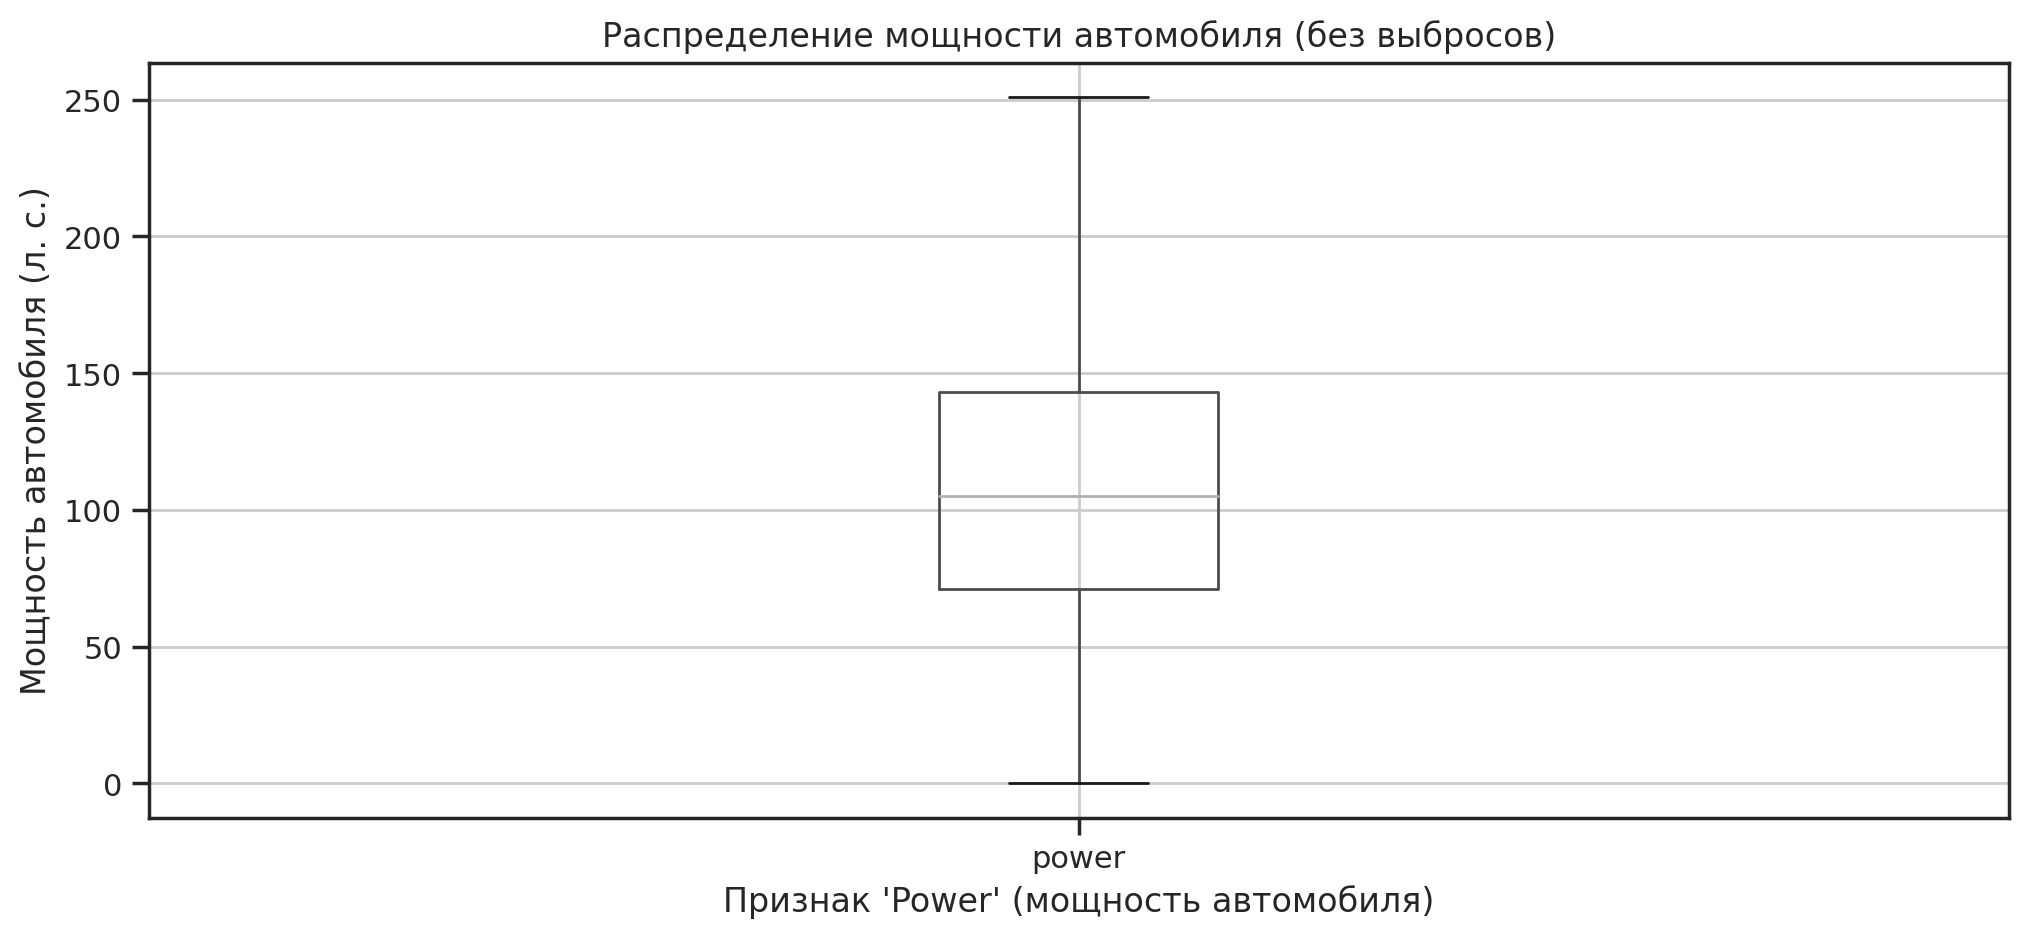

In [25]:
data.boxplot(column='power', showfliers=False, figsize=(12, 5))
plt.xlabel("Признак 'Power' (мощность автомобиля)")
plt.ylabel('Мощность автомобиля (л. с.)')
plt.title('Распределение мощности автомобиля (без выбросов)')
plt.show()

In [26]:
data[data['power'] <= 500].shape[0]

329083

In [27]:
# Заменим нули в признаке Power на медиану по бренду.
data = data[data['power'] <= 500]
data['power'] = data['power'].replace(0, np.NaN) \
.fillna(data.groupby('model')['power'].transform(lambda x: x.median() if x.median() else np.nan))

<div style="border:solid black 2px; padding: 10px">  
    
**Промежуточный вывод:**  
    
**В разделе Исследование данных были выполнены следующие задачи:**. 
1. Произведено изучение данных  
2. Удалены явные дубликаты  
3. Исключены неинформативные признаки  
4. Проведено исследование данных после первоначальной предобработки  
5. Произведена обработка аномалий  
6. Обработаны пропущенные значения  

## Обучение моделей

In [28]:
# Замена категориальных переменных на числовые
data['vehicle_type'] = data['vehicle_type'].astype('category').cat.codes
data['gearbox'] = data['gearbox'].astype('category').cat.codes
data['model'] = data['model'].astype('category').cat.codes
data['fuel_type'] = data['fuel_type'].astype('category').cat.codes
data['brand'] = data['brand'].astype('category').cat.codes
data['repaired'] = data['repaired'].astype('category').cat.codes

# Разделение данных на признаки и целевую переменную
X = data.drop('price', axis=1)
y = data['price']

# Разделение на тренировочный, тестовый и валидационный наборы данных
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [29]:
# Обучение модели LightGBM
start_time = time.time()

params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'rmse',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0,
    'n_jobs': -1
}

lgb_train = lgb.Dataset(X_train, y_train)
lgb_val = lgb.Dataset(X_val, y_val)

model_lgb = lgb.train(params,
                      lgb_train,
                      num_boost_round=1000,
                      valid_sets=[lgb_train, lgb_val],
                      early_stopping_rounds=50,
                      verbose_eval=100)

end_time = time.time()
training_time_lgb = end_time - start_time

# Время обучения модели LightGBM
print("Время обучения LightGBM: %s секунд" % training_time_lgb)

# Время предсказания модели LightGBM
start_time = time.time()
y_pred_lgb = model_lgb.predict(X_test)
end_time = time.time()
prediction_time_lgb = end_time - start_time
print("Время предсказания LightGBM: %s секунд" % prediction_time_lgb)

# Оценка качества модели LightGBM на валидационной выборке
rmse_lgb = mean_squared_error(y_val, model_lgb.predict(X_val), squared=False)
print("RMSE LightGBM на валидационной выборке: %.2f" % rmse_lgb)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.401682 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 1796.99	valid_1's rmse: 1817.65
[200]	training's rmse: 1706.36	valid_1's rmse: 1741.28
[300]	training's rmse: 1658.52	valid_1's rmse: 1706.13
[400]	training's rmse: 1626.38	valid_1's rmse: 1686.63
[500]	training's rmse: 1601.46	valid_1's rmse: 1672.66
[600]	training's rmse: 1582.02	valid_1's rmse: 1663.02
[700]	training's rmse: 1564.55	valid_1's rmse: 1654.22
[800]	training's rmse: 1547.96	valid_1's rmse: 1646.64
[900]	training's rmse: 1535.11	valid_1's rmse: 1640.94
[1000]	training's rmse: 1521.82	valid_1's rmse: 1634.73
Did not meet early stopping. Best iteration is:
[1000]	training's rmse: 1521.82	valid_1's rmse: 1634.73
Время обучения LightGBM: 78.10541296005249 секунд
Время

In [30]:
# Обучение модели CatBoostRegressor
start_time = time.time()

model_catboost = CatBoostRegressor(iterations=1000,
                                   learning_rate=0.1,
                                   depth=6,
                                   loss_function='RMSE',
                                   random_state=42)

model_catboost.fit(X_train, y_train, eval_set=(X_val, y_val), verbose=100, early_stopping_rounds=50)

end_time = time.time()
training_time_catboost = end_time - start_time

# Время обучения модели CatBoostRegressor
print("Время обучения CatBoostRegressor: %s секунд" % training_time_catboost)

# Время предсказания модели CatBoostRegressor
start_time = time.time()
y_pred_catboost = model_catboost.predict(X_test)
end_time = time.time()
prediction_time_catboost = end_time - start_time
print("Время предсказания CatBoostRegressor: %s секунд" % prediction_time_catboost)

# Оценка качества модели CatBoostRegressor на валидационной выборке
rmse_catboost = mean_squared_error(y_val, model_catboost.predict(X_val), squared=False)
print("RMSE CatBoostRegressor на валидационной выборке: %.2f" % rmse_catboost)


0:	learn: 4262.0720118	test: 4277.6542190	best: 4277.6542190 (0)	total: 84.9ms	remaining: 1m 24s
100:	learn: 1839.6365372	test: 1859.6840564	best: 1859.6840564 (100)	total: 2.84s	remaining: 25.3s
200:	learn: 1746.4535386	test: 1774.5226989	best: 1774.5226989 (200)	total: 5.54s	remaining: 22s
300:	learn: 1700.6398365	test: 1739.1199051	best: 1739.1199051 (300)	total: 8.25s	remaining: 19.2s
400:	learn: 1670.0905057	test: 1715.8886607	best: 1715.8886607 (400)	total: 11s	remaining: 16.4s
500:	learn: 1646.1786352	test: 1700.1806305	best: 1700.1806305 (500)	total: 13.6s	remaining: 13.6s
600:	learn: 1627.4495932	test: 1689.1175058	best: 1689.1175058 (600)	total: 16.4s	remaining: 10.9s
700:	learn: 1611.6897914	test: 1679.9486108	best: 1679.9321178 (699)	total: 19.2s	remaining: 8.18s
800:	learn: 1596.6311915	test: 1671.9388727	best: 1671.9009227 (799)	total: 21.8s	remaining: 5.42s
900:	learn: 1583.9295675	test: 1665.3018152	best: 1665.3018152 (900)	total: 24.4s	remaining: 2.68s
999:	learn: 1572

In [31]:
start_time = time.time()

model_xgb = XGBRegressor(n_estimators=1000,
                         learning_rate=0.1,
                         max_depth=10,
                         random_state=12345,
                         subsample=0.8,
                         colsample_bytree=0.8)

model_xgb.fit(X_train, y_train, eval_set=[(X_val, y_val)], early_stopping_rounds=50, verbose=100)

end_time = time.time()
training_time_xgb = end_time - start_time

# Время обучения модели XGBRegressor
print("Время обучения XGBRegressor: %s секунд" % training_time_xgb)

# Время предсказания модели XGBRegressor
start_time = time.time()
y_pred_xgb = model_xgb.predict(X_test)
end_time = time.time()
prediction_time_xgb = end_time - start_time
print("Время предсказания XGBRegressor: %s секунд" % prediction_time_xgb)

# Оценка качества модели XGBRegressor на валидационной выборке
rmse_xgb = mean_squared_error(y_val, model_xgb.predict(X_val), squared=False)
print("RMSE XGBRegressor на валидационной выборке: %.2f" % rmse_xgb)

[0]	validation_0-rmse:5953.03125
[100]	validation_0-rmse:1602.40283
[200]	validation_0-rmse:1583.79468
[300]	validation_0-rmse:1578.23315
[400]	validation_0-rmse:1577.02014
[440]	validation_0-rmse:1577.60498
Время обучения XGBRegressor: 380.0115520954132 секунд
Время предсказания XGBRegressor: 1.9037024974822998 секунд
RMSE XGBRegressor на валидационной выборке: 1576.76


In [32]:
# Заполнение пропущенных значений средними значениями для числовых признаков
X_train = X_train.fillna(X_train.mean())
X_val = X_val.fillna(X_val.mean())
X_test = X_test.fillna(X_test.mean())

# Заполнение пропущенных значений наиболее часто встречающимися значениями для категориальных признаков
X_train = X_train.fillna(X_train.mode().iloc[0])
X_val = X_val.fillna(X_val.mode().iloc[0])
X_test = X_test.fillna(X_test.mode().iloc[0])

In [33]:
start_time = time.time()

# Создаем объект модели линейной регрессии
model_lr = LinearRegression()

# Задаем сетку гиперпараметров для подбора
param_grid = {
    'fit_intercept': [True, False],
    'normalize': [True, False],
    'copy_X': [True, False],
    'n_jobs': [1, -1]
}

# Создаем объект GridSearchCV для подбора гиперпараметров
grid_cv = GridSearchCV(estimator=model_lr, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error')

# Обучаем модель с подбором гиперпараметров
grid_cv.fit(X_train, y_train)

# Получаем лучшие гиперпараметры
best_params = grid_cv.best_params_

# Создаем новую модель с лучшими гиперпараметрами
best_model_lr = LinearRegression(**best_params)

# Обучаем модель на всем обучающем наборе данных
best_model_lr.fit(X_train, y_train)

end_time = time.time()
training_time_lr = end_time - start_time

# Предсказание цен на валидационной выборке
val_predictions_lr = best_model_lr.predict(X_val)

end_time = time.time()
prediction_time_lr = end_time - start_time

# Вычисление RMSE на валидационной выборке
rmse_lr = np.sqrt(mean_squared_error(y_val, val_predictions_lr))

print("Лучшие гиперпараметры модели LinearRegression: ", best_params)
print("RMSE LinearRegression на валидационной выборке: %.2f" % rmse_lr)

Лучшие гиперпараметры модели LinearRegression:  {'copy_X': True, 'fit_intercept': True, 'n_jobs': 1, 'normalize': False}
RMSE LinearRegression на валидационной выборке: 2992.29


In [34]:
# Создание DataFrame с результатами
results = pd.DataFrame({'Model': ['Linear Regression', 'LightGBM', 'CatBoostRegressor', 'XGBRegressor'],
                        'Training Time (sec)': [training_time_lr, training_time_lgb, training_time_catboost, training_time_xgb],
                        'Prediction Time (sec)': [prediction_time_lr, prediction_time_lgb, prediction_time_catboost, prediction_time_xgb],
                        'RMSE (Validation)': [rmse_lr, rmse_lgb, rmse_catboost, rmse_xgb]})

# Вывод результатов
results

,Model,Training Time (sec),Prediction Time (sec),RMSE (Validation)
0,Linear Regression,9.86,9.86,"2,992.29"
1,LightGBM,78.11,6.24,"1,634.73"
2,CatBoostRegressor,29.47,0.06,"1,658.79"
3,XGBRegressor,380.01,1.90,"1,576.76"


## Анализ модели

In [35]:
# Оценка качества модели LightGBM на тестовой выборке
rmse_test = mean_squared_error(y_test, model_xgb.predict(X_test), squared=False)
print("RMSE XGBRegressor на тестовой выборке: %.2f" % rmse_test)

RMSE XGBRegressor на тестовой выборке: 1556.97


<div style="border:solid black 2px; padding: 10px">  
    
**Вывод:**  
    
**В разделе Анализ моделей были выполнены следующие задачи:**. 

1. Выведена таблица сравнения метрик для сравнения моделей;
2. Проанализированы время обучения, время предсказания и качество моделей;
3. Опираясь на критерии заказчика, выбрана лучшая модель, и проверено её качество на тестовой выборке.

В результате выполнения задач этого раздела было выявлено следующее:

Лучшая модель градиентного бустинга XGBRegressor тестовой выборке имеет значение метрики оценки качества *RMSE = 1556.97*.
Во всех моделях значение метрики RMSE не превышает 2500, что соответствует изначальному требованию в условии задачи проекта.

## Чек-лист проверки

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнена загрузка и подготовка данных
- [x]  Выполнено обучение моделей
- [x]  Есть анализ скорости работы и качества моделей